
# PSO–LS-SVM for Hydrochar Carbon Mass Prediction



In [13]:

# Step 1 — Imports
import os, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import plot_cost_history

import seaborn as sns
import shap

plt.rcParams["font.sans-serif"] = ["Times New Roman"]
print("CWD:", os.getcwd())


CWD: C:\Users\check\OneDrive - Kentucky State University\Python Learning


In [14]:

# Step 2 — Load data
def get_data(file_path='sample_htc_data.xlsx', sheet_name='Hydrothermal carbonization'):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data = data.replace([np.nan], 0)
    col_cond = ['mass g','Vessel volume ml','Liquid-to-solid ratio','Carbon content %','Hydrogen content %',
                'Oxygen content %','Reaction temperature','Hold time h','pH']
    col_res = ['Hydrochar carbon mass g']
    for c in col_cond + col_res:
        if c not in data.columns:
            raise ValueError(f"Missing column: {c}")
    original_data = data.copy()
    scaler = StandardScaler()
    data[col_cond] = scaler.fit_transform(data[col_cond])
    X = data[col_cond].values
    y = data[col_res].values.reshape(-1)
    return X, y, original_data, col_cond, scaler

X_all, y_all, original_data, col_cond, scaler = get_data()
print("Shapes:", X_all.shape, y_all.shape)
display(original_data.head())


Shapes: (292, 9) (292,)


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Hydrochar carbon mass g,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,0.0,20.0,50.0,0.066407,0.0,0.0,30.336667,0.0,0.0,Two-step hydrothermal conversion of biomass wa...
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,1.0,20.0,50.0,0.066239,0.0,0.0,30.260000,0.0,0.0,0
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4.0,1.0,20.0,50.0,0.091726,0.0,0.0,41.903333,0.0,0.0,0
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4.0,1.0,20.0,50.0,0.067498,0.0,0.0,30.835000,0.0,0.0,0
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.022480,0.0,0.0,11.240000,0.0,0.0,Hydrothermal humification of lignocellulosic c...


In [15]:

# Step 3 — LS-SVM class
class LSSVM(BaseEstimator):
    def __init__(self, gamma=1.0, kernel='rbf', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma
        self.alpha = None
        self.b = None
        self.X_train = None

    def rbf_kernel(self, X1, X2):
        d2 = np.sum((X1[:, None, :] - X2[None, :, :])**2, axis=2)
        return np.exp(-d2 / (2 * (self.sigma**2)))

    def linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def fit(self, X, y):
        self.X_train = X
        n = X.shape[0]
        if self.kernel == 'rbf':
            K = self.rbf_kernel(X, X)
        elif self.kernel == 'linear':
            K = self.linear_kernel(X, X)
        else:
            raise ValueError("Unsupported kernel type")
        K = K + np.eye(n) / self.gamma
        ones = np.ones((n, 1))
        A = np.block([[K, ones],[ones.T, np.zeros((1,1))]])
        rhs = np.concatenate([y, [0.0]])
        sol = np.linalg.solve(A, rhs)
        self.alpha = sol[:-1]
        self.b = sol[-1]
        return self

    def predict(self, X):
        if self.kernel == 'rbf':
            K = self.rbf_kernel(X, self.X_train)
        elif self.kernel == 'linear':
            K = self.linear_kernel(X, self.X_train)
        else:
            raise ValueError("Unsupported kernel type")
        return np.dot(K, self.alpha) + self.b


In [16]:

# Step 4 — Helpers
def split_indices(n, test_size=0.2, seed=None):
    idx = np.arange(n)
    tr, te = train_test_split(idx, test_size=test_size, random_state=seed)
    return tr, te

def lssvm_model(params, X_train, y_train, X_test):
    gamma, sigma = params
    gamma = max(gamma, 1e-6)
    sigma = max(sigma, 1e-6)
    model = LSSVM(gamma=gamma, kernel='rbf', sigma=sigma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, model

def pso_fitness(P, X_train, y_train, X_test, y_test):
    n_particles = P.shape[0]
    losses = np.zeros(n_particles)
    for i in range(n_particles):
        y_pred, _ = lssvm_model(P[i], X_train, y_train, X_test)
        r2 = r2_score(y_test, y_pred)
        losses[i] = -r2
    return losses


2025-11-17 07:40:30,552 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=-0.978
2025-11-17 07:41:14,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9779874703799035, best pos: [992.416561     3.74840054]


<Figure size 640x480 with 0 Axes>

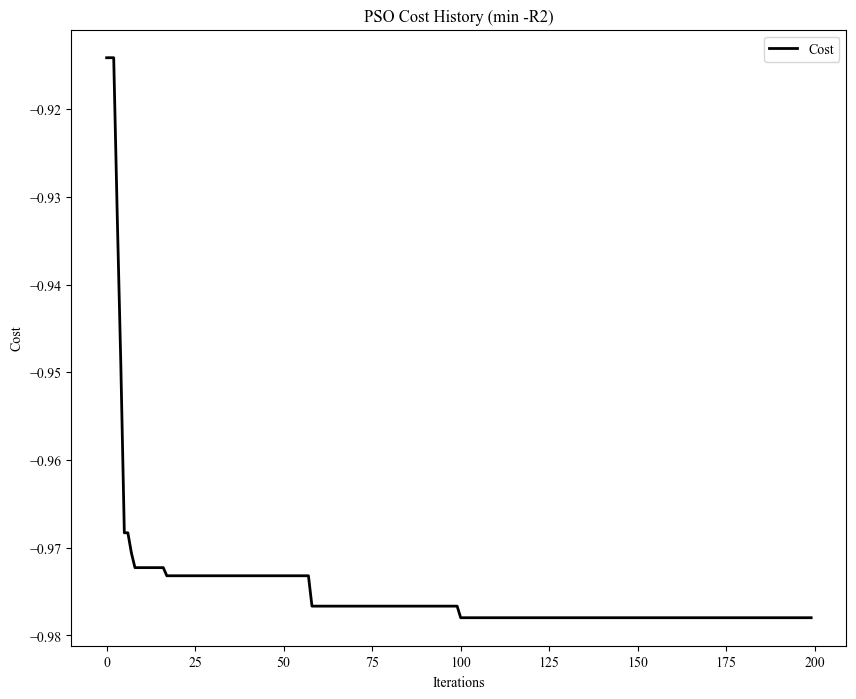

Best [gamma, sigma] = [992.416561     3.74840054]
MAE=0.4907  RMSE=0.8771  R2=0.9780


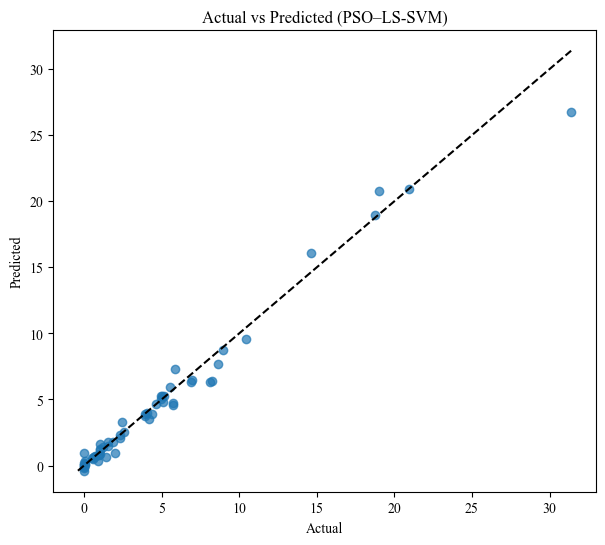

In [17]:

# Step 5 — One PSO–LS-SVM run
train_idx, test_idx = split_indices(len(X_all), test_size=0.2, seed=None)
X_train, X_test = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

n_particles = 20
iters = 200
bounds = (np.array([1e-3, 1e-3]), np.array([1e3, 1e3]))

optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=2,
                          options={'c1':0.5,'c2':0.3,'w':0.9}, bounds=bounds)

best_cost, best_pos = optimizer.optimize(lambda P: pso_fitness(P, X_train, y_train, X_test, y_test),
                                         iters=iters, verbose=True)

plt.figure()
plot_cost_history(optimizer.cost_history)
plt.title('PSO Cost History (min -R2)')
plt.show()

y_pred, model = lssvm_model(best_pos, X_train, y_train, X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best [gamma, sigma] =", best_pos)
print(f"MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (PSO–LS-SVM)')
plt.show()


Saved metrics to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\pso_lssvm_results_202511170744.xlsx


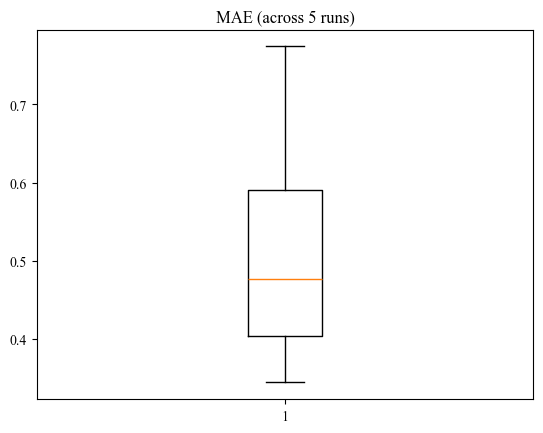

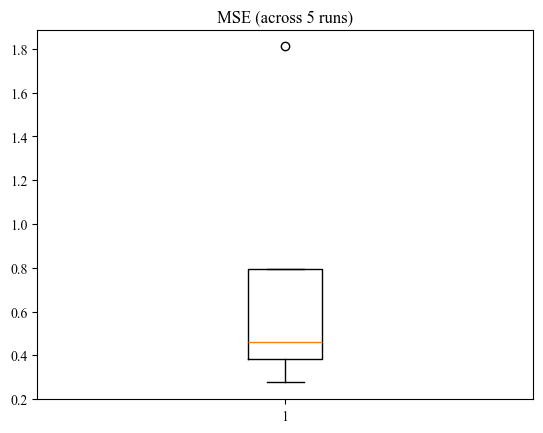

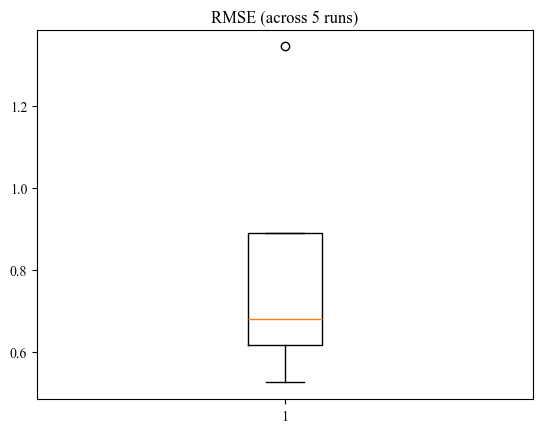

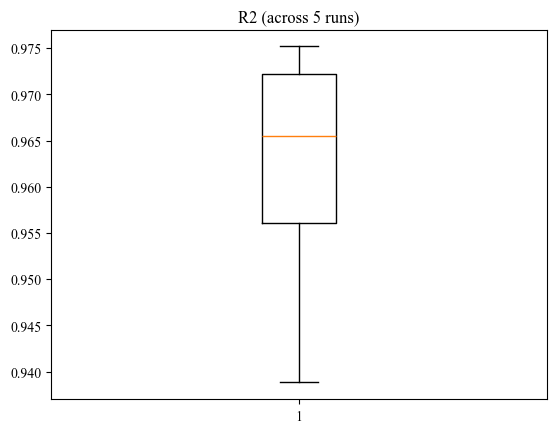

,Iter,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.517901,0.744568,0.811734,0.961566
std,1.581139,0.169990,0.626479,0.327215,0.014672
min,1.000000,0.344445,0.275905,0.525267,0.938826
25%,2.000000,0.404435,0.381572,0.617715,0.956135
50%,3.000000,0.476240,0.462138,0.679807,0.965453
75%,4.000000,0.590250,0.792628,0.890296,0.972225
max,5.000000,0.774135,1.810596,1.345584,0.975194


(0.9751941808066351,
 (3,
  array([54.41764896,  3.58737622]),
  array([261, 251,  59, 235, 105, 191,  71, 185, 181, 203, 194, 127, 156,
         212, 273, 286,  80, 173,  84, 197, 282, 229, 112, 258,  16, 110,
         278,  19,   5,  64,  22,  97, 166, 152, 111, 279, 259, 108, 246,
           8, 268, 164,  93,  24, 204, 248, 211, 233,  52, 168, 104, 139,
          15, 277, 284, 265, 275,  55, 221, 257, 287,  40, 215,  33, 239,
         291, 106, 117, 171,  61, 267, 198,  12,  29, 226, 154, 146,  70,
         214, 262, 128,  51,  18,  28,  21,  10, 281, 151,   1, 170, 276,
         120, 263, 208,  41, 153,  13,  72,  57,  77,  79, 125,  11, 271,
         260, 188,  30, 232,  35, 207,  54, 269, 178,  91, 113, 116, 199,
         109, 186, 149,  87, 217, 272,  23,  76, 240, 202, 227, 224, 148,
          58,  78,  48, 238, 228, 132,  65, 216, 165, 218, 236, 138,  17,
          90, 101, 270, 205, 163, 209, 102, 180,  66,  89, 190,  82,  63,
          62,  99,  42, 123,  27, 140, 160, 167, 

In [18]:

# Step 6 — Repeat runs for stability + save metrics
n_runs = 5
records = []
best_overall = (-np.inf, None)

for i in range(n_runs):
    tr, te = split_indices(len(X_all), test_size=0.2, seed=None)
    X_tr, X_te = X_all[tr], X_all[te]
    y_tr, y_te = y_all[tr], y_all[te]

    opt = GlobalBestPSO(n_particles=20, dimensions=2,
                        options={'c1':0.5,'c2':0.3,'w':0.9}, bounds=(np.array([1e-3,1e-3]), np.array([1e3,1e3])))
    bc, bp = opt.optimize(lambda P: pso_fitness(P, X_tr, y_tr, X_te, y_te), iters=200, verbose=False)

    y_pi, m_i = lssvm_model(bp, X_tr, y_tr, X_te)
    mae_i = mean_absolute_error(y_te, y_pi)
    mse_i = mean_squared_error(y_te, y_pi)
    rmse_i = np.sqrt(mse_i)
    r2_i = r2_score(y_te, y_pi)

    records.append([i+1, mae_i, mse_i, rmse_i, r2_i, bp, tr, te])
    if r2_i > best_overall[0]:
        best_overall = (r2_i, (i+1, bp, tr, te, m_i))

metrics_df = pd.DataFrame(records, columns=["Iter","MAE","MSE","RMSE","R2","BestParams","TrainIdx","TestIdx"])
now = datetime.datetime.now().strftime('%Y%m%d%H%M')
out_metrics = f"pso_lssvm_results_{now}.xlsx"
metrics_df.to_excel(out_metrics, index=False)
print("Saved metrics to:", os.path.abspath(out_metrics))

for label in ["MAE","MSE","RMSE","R2"]:
    plt.figure()
    plt.boxplot(metrics_df[label].values)
    plt.title(f"{label} (across {n_runs} runs)")
    plt.show()

display(metrics_df.describe())
best_overall


Best iter=3, R2=0.9752, params=[54.41764896  3.58737622]


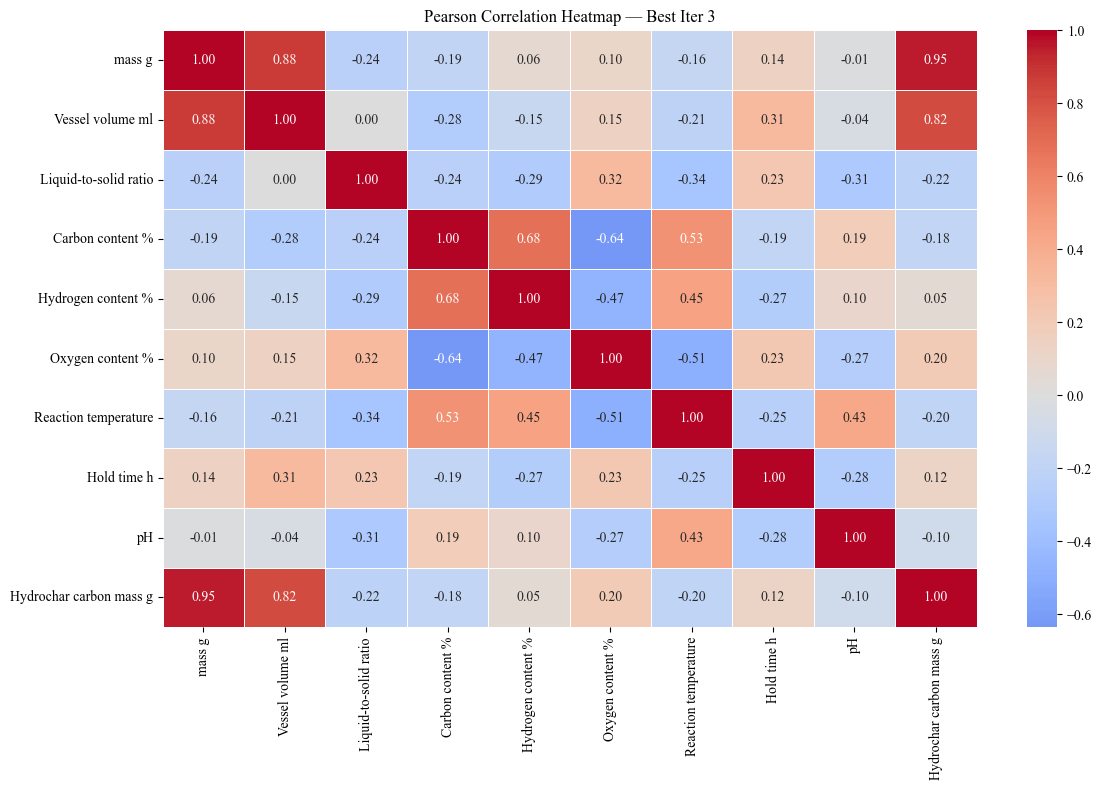

  0%|          | 0/30 [00:00<?, ?it/s]

2025-11-17 07:44:47,601 - shap - INFO - num_full_subsets = 4
2025-11-17 07:44:48,379 - shap - INFO - np.sum(w_aug) = np.float64(9.0)
2025-11-17 07:44:48,379 - shap - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-11-17 07:44:48,401 - shap - INFO - phi = array([-0.61625297, -0.08162419,  0.09354263,  0.47157187, -0.01900718,
       -0.35995339,  0.00637807,  0.02793148, -0.05835777])
2025-11-17 07:44:48,419 - shap - INFO - num_full_subsets = 4
2025-11-17 07:44:49,136 - shap - INFO - np.sum(w_aug) = np.float64(9.0)
2025-11-17 07:44:49,136 - shap - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-11-17 07:44:49,145 - shap - INFO - phi = array([-1.59723862,  0.54567666, -0.30818058, -0.20245241, -0.03859671,
       -0.84607162, -0.05938926, -0.11527011, -0.1012384 ])
2025-11-17 07:44:49,155 - shap - INFO - num_full_subsets = 4
2025-11-17 07:44:49,788 - shap - INFO - np.sum(w_aug) = np.float64(9.0)
2025-11-17 07:44:49,788 - shap - INFO - np.sum(self.kernelWeights) = np.flo

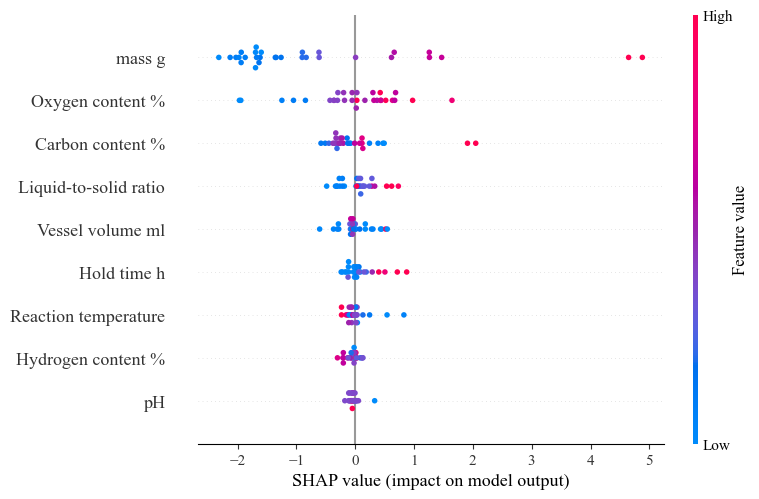

In [19]:

# Step 7 — Analyze best run: correlation + SHAP
best_r2, pack = best_overall
best_iter, best_params, tr_idx, te_idx, best_model = pack
print(f"Best iter={best_iter}, R2={best_r2:.4f}, params={best_params}")

test_df = original_data.iloc[te_idx].copy()
corr = test_df[col_cond + ['Hydrochar carbon mass g']].corr(method='pearson')
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title(f"Pearson Correlation Heatmap — Best Iter {best_iter}")
plt.tight_layout()
plt.show()

# SHAP with small background and a small explain set (scaled features)
X_tr = X_all[tr_idx]
X_te = X_all[te_idx]
X_bg = X_tr[:40] if X_tr.shape[0] > 40 else X_tr
X_ex = X_te[:30] if X_te.shape[0] > 30 else X_te

explainer = shap.KernelExplainer(best_model.predict, X_bg)
shap_values = explainer.shap_values(X_ex)
shap.summary_plot(shap_values, X_ex, feature_names=col_cond)


In [20]:

# Step 8 — Create + predict on 'new_data_for_prediction.xlsx'
new_file = "new_data_for_prediction.xlsx"
if not os.path.exists(new_file):
    tmp = original_data[col_cond].head(5).copy()
    tmp.to_excel(new_file, index=False)
    print("Created:", os.path.abspath(new_file))

new_df = pd.read_excel(new_file)
X_new = scaler.transform(new_df[col_cond])
y_new = best_model.predict(X_new)

out_pred = f"pso_lssvm_predictions_{datetime.datetime.now().strftime('%Y%m%d%H%M')}.xlsx"
pred_df = new_df.copy()
pred_df['Predicted_Hydrochar_carbon_mass_g'] = y_new
pred_df.to_excel(out_pred, index=False)
print("Saved predictions to:", os.path.abspath(out_pred))
display(pred_df)


Saved predictions to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\pso_lssvm_predictions_202511170745.xlsx


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References,Predicted_Hydrochar_carbon_mass_g
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4,0,20,50,0,0,30.336667,0,0,Two-step hydrothermal conversion of biomass wa...,0.239100
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4,1,20,50,0,0,30.260000,0,0,0,0.042227
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4,1,20,50,0,0,41.903333,0,0,0,0.428720
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4,1,20,50,0,0,30.835000,0,0,0,-0.301871
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4,1,20,50,0,0,11.240000,0,0,Hydrothermal humification of lignocellulosic c...,0.034617
